# Introduction to LCEL and LangGraph: LangChain Powered RAG

In the following notebook we're going to focus on learning how to navigate and build useful applications using LangChain, specifically LCEL, and how to integrate different APIs together into a coherent RAG application!

We'll be building a RAG system to answer questions about how people use AI, using the "How People Use AI" dataset.

In the notebook, you'll complete the following Tasks:

- 🤝 Breakout Room #2:
    1. LangChain and LCEL Concepts
    2. Understanding States and Nodes
    3. Introduction to QDrant Vector Databases
    4. Building a Basic Graph

Let's get started!



## Installation Requirements

Also, make sure Ollama is installed and running with the required models pulled (see instructions below).


## Optional: LangSmith Setup for Tracing and Monitoring

LangSmith provides powerful tracing, monitoring, and debugging capabilities for LangChain applications. While not required for this notebook, setting it up will give you valuable insights into your RAG system's performance.

### Getting LangSmith Credentials

1. **Sign up for LangSmith**: Visit [smith.langchain.com](https://smith.langchain.com) and create a free account
2. **Get your API Key**: 
   - Go to Settings → API Keys
   - Create a new API key and copy it
3. **Set your environment variables** (choose one method below):

**Option A: Set environment variables in your terminal before starting Jupyter:**
```bash
export LANGCHAIN_TRACING_V2=true
export LANGCHAIN_API_KEY="your-api-key-here"
export LANGCHAIN_PROJECT="RAG-Assignment"
```

**Option B: Set them in the notebook (run the cell below):**


In [ ]:
# Optional: Set up LangSmith tracing
# Uncomment and fill in your credentials if you want to use LangSmith

import os
import getpass

# Uncomment the lines below to enable LangSmith tracing
# os.environ["LANGCHAIN_TRACING_V2"] = "true"
# os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("Enter your LangSmith API key: ")
# os.environ["LANGCHAIN_PROJECT"] = "RAG-Assignment"

# Verify setup (uncomment to check)
# print("LangSmith tracing enabled:", os.getenv("LANGCHAIN_TRACING_V2", "false"))
# print("Project name:", os.getenv("LANGCHAIN_PROJECT", "Not set"))


LangSmith tracing enabled: true
Project name: RAG-Assignment


### What LangSmith Provides

Once set up, LangSmith will automatically trace your LangChain operations and provide:

- **Execution traces**: See exactly how your RAG pipeline processes each query
- **Performance metrics**: Monitor latency, token usage, and costs
- **Debugging tools**: Inspect intermediate outputs at each step
- **Error tracking**: Identify and debug issues in your chains
- **Dataset management**: Collect and organize your queries and responses

You can view all traces and analytics in your LangSmith dashboard at [smith.langchain.com](https://smith.langchain.com).

> **Note**: LangSmith is completely optional for this assignment. The notebook will work perfectly fine without it, but it's a valuable tool for production applications.


# 🤝 Breakout Room #2

## Set Up Ollama

We'll be using Ollama to run local LLM models. Make sure you have Ollama installed and running:

1. Install Ollama from https://ollama.ai (`curl https://ollama.ai/install.sh | sh`)
2. Make sure the output of `ollama -v` reads `0.11.10` or greater.
2. Pull the models we'll use:
   ```bash
   ollama pull gpt-oss:20b # For the chat model
   ollama pull embeddinggemma:latest  # For embeddings
   ```
3. Ensure Ollama is running (it should start automatically after installation)

### A Note On Runnables

# Understanding LangChain Runnables and LCEL

In LangChain, a Runnable is like a LEGO brick in your AI application - it's a standardized component that can be easily connected with other components. The real power of Runnables comes from their ability to be combined in flexible ways using LCEL (LangChain Expression Language).

## Key Features of Runnables

### 1. Universal Interface
Every Runnable in LangChain follows the same pattern:
- Takes an input
- Performs some operation
- Returns an output

This consistency means you can treat different components (like models, retrievers, or parsers) in the same way.

### 2. Built-in Parallelization
Runnables come with methods for handling multiple inputs efficiently:
```python
# Process inputs in parallel, maintain order
results = chain.batch([input1, input2, input3])

# Process inputs as they complete
for result in chain.batch_as_completed([input1, input2, input3]):
    print(result)
```

### 3. Streaming Support
Perfect for responsive applications:
```python
# Stream outputs as they're generated
for chunk in chain.stream({"query": "Tell me a story"}):
    print(chunk, end="", flush=True)
```

### 4. Easy Composition
The `|` operator makes building pipelines intuitive:
```python
# Create a basic RAG chain
rag_chain = retriever | prompt | model | output_parser
```

## Common Types of Runnables

- **Language Models**: Like our `ChatOllama` instance (running locally with Ollama)
- **Prompt Templates**: Format inputs consistently
- **Retrievers**: Get relevant context from a vector store
- **Output Parsers**: Structure model outputs
- **LangGraph Nodes**: Individual components in our graph

Think of Runnables as the building blocks of your LLM application. Just like how you can combine LEGO bricks in countless ways, you can mix and match Runnables to create increasingly sophisticated applications!



## LangGraph Based RAG

Now that we have a reasonable grasp of LCEL and the idea of Runnables - let's see how we can use LangGraph to build the same system!

### Primer: What is LangGraph?
LangGraph is a tool that leverages LangChain Expression Language to build coordinated multi-actor and stateful applications that includes cyclic behaviour.

#### Why Cycles?
In essence, we can think of a cycle in our graph as a more robust and customizable loop. It allows us to keep our application agent-forward while still giving the powerful functionality of traditional loops.

Due to the inclusion of cycles over loops, we can also compose rather complex flows through our graph in a much more readable and natural fashion. Effectively allowing us to recreate application flowcharts in code in an almost 1-to-1 fashion.

#### Why LangGraph?
Beyond the agent-forward approach - we can easily compose and combine traditional "DAG" (directed acyclic graph) chains with powerful cyclic behaviour due to the tight integration with LCEL. This means it's a natural extension to LangChain's core offerings!

> NOTE: We're going to focus on building a simple DAG for today's assignment as an introduction to LangGraph

### Putting the State in Stateful

Earlier we used this phrasing:

> coordinated multi-actor and stateful applications

So what does that "stateful" mean?

To put it simply - we want to have some kind of object which we can pass around our application that holds information about what the current situation (state) is. Since our system will be constructed of many parts moving in a coordinated fashion - we want to be able to ensure we have some commonly understood idea of that state.

LangGraph leverages a `StatefulGraph` which uses an `AgentState` object to pass information between the various nodes of the graph.

There are more options than what we'll see below - but this `AgentState` object is one that is stored in a `TypedDict` with the key `messages` and the value is a `Sequence` of `BaseMessages` that will be appended to whenever the state changes.

However, in our example here, we're focusing on a simpler `State` object:

```python
class State(TypedDict):
    question: str
    context: list[Document]
    response: str
```

Let's think about a simple example to help understand exactly what this means (we'll simplify a great deal to try and clearly communicate what state is doing):

1. **We initialize our state object**:
   ```python
   {
       "question": "",
       "context": [],
       "response": ""
   }
   ```

2. **Our user submits a query to our application.**  
   We store the user's question in `state["question"]`. Now we have:
   ```python
   {
       "question": "How tall is the Eiffel Tower?",
       "context": [],
       "response": ""
   }
   ```

3. **We pass our state object to an Agent node** which is able to read the current state. It will use the value of `state["question"]` as input and might retrieve some context documents related to the question. It then generates a response which it stores in `state["response"]`. For example:
   ```python
   {
       "question": "How tall is the Eiffel Tower?",
       "context": [Document(page_content="...some data...")],
       "response": "The Eiffel Tower is about 324 meters tall..."
   }
   ```

That's it! The important part is that we have a consistent object (`State`) that's passed around, holding the crucial information as we go from one node to the next. This ensures our application has a single source of truth about what has happened so far and what is happening now.



In [3]:
from langgraph.graph import START, StateGraph
from typing_extensions import TypedDict
from langchain_core.documents import Document

class State(TypedDict):
  question: str
  context: list[Document]
  response: str

Now that we have state, and we have tools, and we have an LLM - we can finally start making our graph!

Let's take a second to refresh ourselves about what a graph is in this context.

Graphs, also called networks in some circles, are a collection of connected objects.

The objects in question are typically called nodes, or vertices, and the connections are called edges.

Let's look at a simple graph.

![image](https://i.imgur.com/2NFLnIc.png)

Here, we're using the coloured circles to represent the nodes and the yellow lines to represent the edges. In this case, we're looking at a fully connected graph - where each node is connected by an edge to each other node.

If we were to think about nodes in the context of LangGraph - we would think of a function, or an LCEL Runnable.

If we were to think about edges in the context of LangGraph - we might think of them as "paths to take" or "where to pass our state object next".  

### Building Nodes

We're going to need two nodes:

A node for retrieval, and a node for generation.

Let's start with our `retrieve` node!

Notice how we do not need to update the state object in the node, but can instead return a modification directly to our state.

#### Building a Retriever with LangChain

In order to build our `retrieve` node, we'll first need to build a retriever!

This will involve the following steps: 

1. Ingesting Data
2. Chunking the Data
3. Vectorizing the Data and Storing it in a Vector Database
4. Converting it to a Retriever

##### Retreiver Step 1: Ingesting Data

In today's lesson, we're going to be building a RAG system to answer questions about how people use AI - and we will pull information into our index (vectorized chunks stored in our vector store) through LangChain's [`PyMuPDFLoader`](https://python.langchain.com/api_reference/community/document_loaders/langchain_community.document_loaders.pdf.PyMuPDFLoader.html)!

> NOTE: We'll be using an async loader during our document ingesting - but our Jupyter Kernel is already running in an asyc loop! This means we'll want the ability to *nest* async loops. 

In [4]:
import nest_asyncio

nest_asyncio.apply()

Now, we're good to load our documents through the [`PyMuPDFLoader`](https://python.langchain.com/api_reference/community/document_loaders/langchain_community.document_loaders.pdf.PyMuPDFLoader.html)!

In [5]:
from langchain_community.document_loaders import DirectoryLoader
from langchain_community.document_loaders import PyMuPDFLoader

directory_loader = DirectoryLoader("data", glob="**/*.pdf", loader_cls=PyMuPDFLoader)

ai_usage_knowledge_resources = directory_loader.load()

In [6]:
ai_usage_knowledge_resources[0].page_content[:1000]

'NBER WORKING PAPER SERIES\nHOW PEOPLE USE CHATGPT\nAaron Chatterji\nThomas Cunningham\nDavid J. Deming\nZoe Hitzig\nChristopher Ong\nCarl Yan Shan\nKevin Wadman\nWorking Paper 34255\nhttp://www.nber.org/papers/w34255\nNATIONAL BUREAU OF ECONOMIC RESEARCH\n1050 Massachusetts Avenue\nCambridge, MA 02138\nSeptember 2025\nWe acknowledge help and comments from Joshua Achiam, Hemanth Asirvatham, Ryan \nBeiermeister, Rachel Brown, Cassandra Duchan Solis, Jason Kwon, Elliott Mokski, Kevin Rao, \nHarrison Satcher, Gawesha Weeratunga, Hannah Wong, and Analytics & Insights team. We \nespecially thank Tyna Eloundou and Pamela Mishkin who in several ways laid the foundation for \nthis work. This study was approved by Harvard IRB (IRB25-0983). A repository containing all \ncode run to produce the analyses in this paper is available on request. The views expressed herein \nare those of the authors and do not necessarily reflect the views of the National Bureau of \nEconomic Research.\nAt least one c

#### TextSplitting aka Chunking

We'll use the `RecursiveCharacterTextSplitter` to create our toy example.

It will split based on the following rules:

- Each chunk has a maximum size of 1000 tokens
- It will try and split first on the `\n\n` character, then on the `\n`, then on the `<SPACE>` character, and finally it will split on individual tokens.

Let's implement it and see the results!

In [7]:
import tiktoken
from langchain.text_splitter import RecursiveCharacterTextSplitter

def tiktoken_len(text):
    # Using cl100k_base encoding which is a good general-purpose tokenizer
    # This works well for estimating token counts even with Ollama models
    tokens = tiktoken.get_encoding("cl100k_base").encode(
        text,
    )
    return len(tokens)

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 750,
    chunk_overlap = 0,
    length_function = tiktoken_len,
)

In [8]:
ai_usage_knowledge_chunks = text_splitter.split_documents(ai_usage_knowledge_resources)

##### 🏗️ Activity #1:

While there's nothing specifically wrong with the chunking method used above - it is a naive approach that is not sensitive to specific data formats.

Brainstorm some ideas that would split large single documents into smaller documents.

1. Semantic chunking. Use sentence level embeddings and cluster on similarity of sentences. Then chunk when the similarity goes below a certain threshold or value.
2. Could split by document structure entirely. Look for markdown or ascii characters. Something that would symbolize H1, H2, p, /n, /t, etc.
3. Probably less beneficial but we could split upon randomness. Split into a chunk of target size of a random integer over and over until the document is fully split.

#### Embeddings and Dense Vector Search

Now that we have our individual chunks, we need a system to correctly select the relevant pieces of information to answer our query.

This sounds like a perfect job for embeddings!

We'll be using Ollama's `embeddinggemma` model as our embedding model today! This is a powerful open-source embedding model that runs locally.

Let's load it up through LangChain.

In [9]:
from langchain_ollama import OllamaEmbeddings
 
# Using embeddinggemma which is a powerful open-source embedding model
embedding_model = OllamaEmbeddings(model="embeddinggemma:latest")

##### ❓ Question #1:

What is the embedding dimension, given that we're using `embeddinggemma`?

You will need to fill the next cell out correctly with your embedding dimension for the rest of the notebook to run.

In [10]:
# Answer here: https://ai.google.dev/gemma/docs/embeddinggemma/model_card
embedding_dim = 768

#### Using A Vector Database - Intoduction to Qdrant

Up to this point, we've been using a dictionary to hold our embeddings - typically, we'll want to use a more robust strategy.

In this bootcamp - we'll be focusing on leveraging [Qdrant's vector database](https://qdrant.tech/qdrant-vector-database/).

Let's take a look at how we set-up Qdrant!

> NOTE: We'll be spending a lot of time learning about Qdrant throughout the remainder of our time together - but for an initial primer, please check out [this resource](https://qdrant.tech/articles/what-is-a-vector-database/)

We are going to be using an "in-memory" Qdrant client, which means that our vectors will be held in our system's memory (RAM) - this is useful for prototyping and developement at smaller scales - but would need to be modified when moving to production. Luckily for us, this modification is trivial!

> NOTE: While LangChain uses the terminology "VectorStore" (also known as a Vector Library), Qdrant is a "Vector Database" - more info. on that [here.](https://weaviate.io/blog/vector-library-vs-vector-database)

In [11]:
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

client = QdrantClient(":memory:")

Next, we need to create a collection - a collection is a specific...collection of vectors within the Qdrant client.

These are useful as they allow us to create multiple different "warehouses" in a single client, which can be leveraged for personalization and more!

Also notice that we define what our vector shapes are (embedding dim) as well as our desired distance metric.

In [12]:
client.create_collection(
    collection_name="ai_usage_knowledge_index",
    vectors_config=VectorParams(size=embedding_dim, distance=Distance.COSINE),
)

True

Now we can assemble our vector database! Notice that we provide our client, our created collection, and our embedding model!

In [13]:
vector_store = QdrantVectorStore(
    client=client,
    collection_name="ai_usage_knowledge_index",
    embedding=embedding_model,
)

Now that we have our vector database set-up, we can add our documents into it!

In [14]:
_ = vector_store.add_documents(documents=ai_usage_knowledge_chunks)

#### Creating a Retriever

Now that we have an idea of how we're getting our most relevant information - let's see how we could create a pipeline that would automatically extract the closest chunk to our query and use it as context for our prompt!

This will involve a popular LangChain interace known as `as_retriever`!

> NOTE: We can still specify how many documents we wish to retrieve per vector.

In [15]:
retriever = vector_store.as_retriever(search_kwargs={"k": 5})

In [16]:
retriever.invoke("How do people use AI in their daily work?")

[Document(metadata={'producer': 'macOS Version 15.4.1 (Build 24E263) Quartz PDFContext, AppendMode 1.1', 'creator': 'LaTeX with hyperref', 'creationdate': '2025-09-12T20:05:32+00:00', 'source': 'data/howpeopleuseai.pdf', 'file_path': 'data/howpeopleuseai.pdf', 'total_pages': 64, 'format': 'PDF 1.6', 'title': 'How People Use ChatGPT', 'author': '', 'subject': '', 'keywords': '', 'moddate': '2025-09-15T10:32:36-04:00', 'trapped': '', 'modDate': "D:20250915103236-04'00'", 'creationDate': 'D:20250912200532Z', 'page': 34, '_id': '8091e102391a448398f7567362478298', '_collection_name': 'ai_usage_knowledge_index'}, page_content='Panel A. Work Related\nPanel B1. Asking.\nPanel B2. Doing.\nFigure 23: (continued on next page)\n33'),
 Document(metadata={'producer': 'macOS Version 15.4.1 (Build 24E263) Quartz PDFContext, AppendMode 1.1', 'creator': 'LaTeX with hyperref', 'creationdate': '2025-09-12T20:05:32+00:00', 'source': 'data/howpeopleuseai.pdf', 'file_path': 'data/howpeopleuseai.pdf', 'total_

#### Creating the Node

We're finally ready to create our node!

In [17]:
def retrieve(state: State) -> State:
  retrieved_docs = retriever.invoke(state["question"])
  return {"context" : retrieved_docs}

### Generate Node

Next, let's create our `generate` node - which will leverage LangChain and something called an "LCEL Chain" which you can read more about [here](https://python.langchain.com/docs/concepts/lcel/)!

We'll want to create a chain that does the following: 

1. Formats our inputs into a chat template suitable for RAG
2. Takes that chat template and sends it to an LLM
3. Parses that output into `str` format

Let's get chaining!

#### Chain Components: RAG Chat Template

We'll create a chat template that takes in some query and formats it as a RAG prompt using LangChain's prompt template!

In [18]:
from langchain_core.prompts import ChatPromptTemplate

HUMAN_TEMPLATE = """
#CONTEXT:
{context}

QUERY:
{query}

Use the provide context to answer the provided user query. Only use the provided context to answer the query. If you do not know the answer, or it's not contained in the provided context response with "I don't know"
"""

chat_prompt = ChatPromptTemplate.from_messages([
    ("human", HUMAN_TEMPLATE)
])

In [19]:
chat_prompt.invoke({"context" : "OUR CONTEXT HERE", "query" : "OUR QUERY HERE"}).messages[0].content

'\n#CONTEXT:\nOUR CONTEXT HERE\n\nQUERY:\nOUR QUERY HERE\n\nUse the provide context to answer the provided user query. Only use the provided context to answer the query. If you do not know the answer, or it\'s not contained in the provided context response with "I don\'t know"\n'

##### Chain Components: Generator

We'll next set-up the generator - which will be Ollama's `gpt-oss:20b` model running locally!

In [20]:
from langchain_ollama import ChatOllama

# Using gpt-oss:20b which is a powerful and efficient local model
ollama_chat_model = ChatOllama(model="gpt-oss:20b", temperature=0.6)

Let's now call our model with a formatted prompt.

Notice that we have some nested calls here - we'll see that this is made easier by LCEL.

In [21]:
ollama_chat_model.invoke(chat_prompt.invoke({"context" : "Paris is the capital of France", "query" : "What is the capital of France?"}))

AIMessage(content='Paris', additional_kwargs={}, response_metadata={'model': 'gpt-oss:20b', 'created_at': '2025-09-19T19:07:39.852887Z', 'done': True, 'done_reason': 'stop', 'total_duration': 3735807792, 'load_duration': 2141862417, 'prompt_eval_count': 132, 'prompt_eval_duration': 687048875, 'eval_count': 51, 'eval_duration': 906183292, 'model_name': 'gpt-oss:20b'}, id='run--5ea94e69-428f-4f99-a017-5cf442a63612-0', usage_metadata={'input_tokens': 132, 'output_tokens': 51, 'total_tokens': 183})

#### Chain Components: `str` Parser

Finally, let's set-up our `StrOutputParser()` which will transform our model's output into a simple `str` to be provided to the user.

> NOTE: You can see us leveraging LCEL in the example below to avoid needing to do nested calls.

In [22]:
from langchain_core.output_parsers import StrOutputParser

generator_chain = chat_prompt | ollama_chat_model | StrOutputParser()

generator_chain.invoke({"context" : "Paris is the capital of France", "query" : "What is the capital of France?"})

'Paris.'

### `generate` Node: 

Now we can create our `generate` Node!

In [23]:
def generate(state: State) -> State:
  generator_chain = chat_prompt | ollama_chat_model | StrOutputParser()
  response = generator_chain.invoke({"query" : state["question"], "context" : state["context"]})
  return {"response" : response}

Now we can start defining our graph!

Think of the graph's state as a blank canvas that we can add nodes and edges to.

Every graph starts with two special nodes - START and END - the act as the entry and exit point to the other nodes in the graphs.  

All valid graphs must start at the START node and end at the END node.

In [24]:
# Start with the blank canvas
graph_builder = StateGraph(State)

Now we can add a sequence to our "canvas" (graph) - this can be done by providing a list of nodes, the will automatically have edges that connect the i-th element to the i+1-th element in the list. The final element will be added to the END node unless otherwise specified.

In [25]:
graph_builder = graph_builder.add_sequence([retrieve, generate])

Next, let's connect our START node to our `retrieve` node by adding an edge.

In [26]:
graph_builder.add_edge(START, "retrieve")

Finally we can compile our graph! This will do basic verification to ensure that the Runnables have the correct inputs/outputs and can be matched.

In [27]:
graph = graph_builder.compile()

Finally, we can visualize our graph!

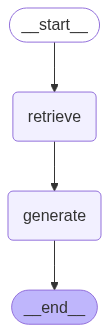

In [28]:
graph

Let's take it for a spin!

We invoke our graph like we do any other Runnable in LCEL!

> NOTE: That's right, even a compiled graph is a Runnable!

In [29]:
from IPython.display import Markdown, display
response = graph.invoke({"question" : "What are the most common ways people use AI in their work?"})
display(Markdown(response["response"]))

**Most common ways people use AI at work**

The figure from the study shows that the bulk of work‑related AI use falls into three functional categories:

| Category | What it means | Typical examples |
|----------|---------------|------------------|
| **Panel B1 – Asking** | Using the model to get information, explanations, or advice | “What’s the best way to structure a presentation?” “How do I fix this Python error?” |
| **Panel B2 – Doing** | Using the model to actually produce or transform content | Drafting emails, writing code, generating reports, editing documents |
| **Panel B3 – Expressing** | Using the model to help articulate ideas or communicate more effectively | Re‑phrasing a message to be friendlier, creating a summary, brainstorming ideas |

These three modes—**asking for help, doing tasks, and expressing ideas**—represent the most common ways people employ AI tools in their day‑to‑day work.

In [30]:
response = graph.invoke({"question" : "Do people use AI for their personal lives?"})
display(Markdown(response["response"]))

Yes.  
The study includes examples of people using ChatGPT for personal‑life tasks, such as:

* “User is rewriting an email to neighbors about plumbing to be more friendly”  
* “User is complaining about grandmother”

These illustrate that users employ AI for everyday personal matters.

In [31]:
response = graph.invoke({"question" : "What concerns or challenges do people have when using AI?"})
display(Markdown(response["response"]))

Based on the excerpts provided, the main concern highlighted is that **people may not report their use of AI accurately because of social‑desirability bias**. The cited study (“Underreporting of AI use: The role of social desirability bias”) indicates that respondents often understate or conceal how much they rely on AI tools, making it challenging to assess true usage patterns.

In [32]:
response = graph.invoke({"question" : "Who is Batman?"})
display(Markdown(response["response"]))

I don't know.

#### ❓ Question #2:
LangGraph's graph-based approach lets us visualize and manage complex flows naturally. How could we extend our current implementation to handle edge cases? For example:
- What if the retriever finds no relevant context?  
- What if the response needs fact-checking?
Consider how you would modify the graph to handle these scenarios.

##### ✅ Answers
2.1 #Your answer here
The current implementation would still try to generate a response. The response could be very poor or empty. What we could do to better this is add a context validation node (or a node of this sort) that evaluates the quality of the retrtieved data. This would require adding conditional edges to our graph.

2.2 #Your answer here
If the respons needs fact checking, I think we would certainly benefit (need?) a new node. It can cross-reference and validate facts against the original source or any sources we give it. We could add some type of metric to track qualtiy/confidence.

Overall, I think this pushes for more nodes to handle necessary edge cases like these two questions.